In [2]:
!pip install corner

import functools
import time

import jax.random
import optax
import tensorflow_probability.substrates.jax as tfp
from jax import jit, pmap, grad, vmap
from jax import numpy as jnp
from tensorflow_probability.substrates.jax import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import tensorflow_probability.substrates.jax as tfp
import jax
from scipy.optimize import minimize
from jax import random
import optax
from jax import numpy as jnp
tfd = tfp.distributions
from corner import corner


J es: 0.04700896143913269 A/cm^2
0.021157671428389018


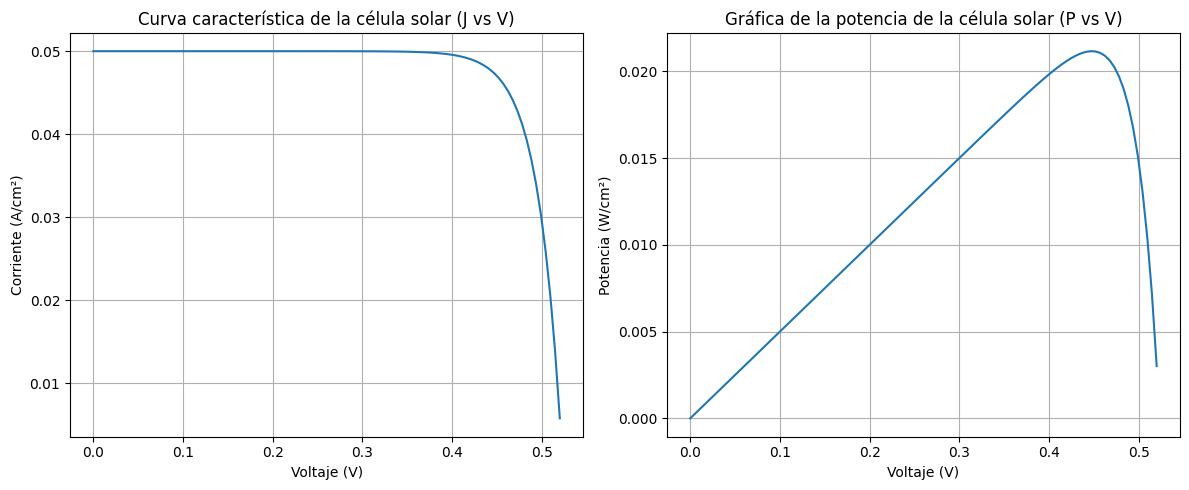

In [3]:
#2b
import numpy as np
import math

# Constantes de la tabla
q = 1.602176634e-19  # Carga elemental en C
k = 1.3880649e-23  # Constante de Boltzmann en J/K
T = 300  # Temperatura en K
D_n = 2  # Coeficiente de difusión de electrones en cm^2/s
D_p = 11.6  # Coeficiente de difusión de huecos en cm^2/s
tau_n = 371e-6  # Tiempo de vida de electrones en s
tau_p = 3710e-6  # Tiempo de vida de huecos en s
N_A = 4.7e15  # Concentración de aceptores en cm^-3
N_D = 1e20  # Concentración de donadores en cm^-3
W_n = 0.2e-4  # Ancho de la región n en cm
W_p = 179.8e-4  # Ancho de la región p en cm
epsilon = 1.035918e-12  # Permitividad eléctrica del silicio en F/cm
n_i = 9.696e9  # Concentración intrínseca de portadores en cm^-3


V_int = (k * T / q) * jnp.log(N_A * N_D / n_i**2)
# Fórmulas para calcular X_n y X_p
def calculate_X_n(V_int, epsilon, q, N_A, N_D):
    return jnp.sqrt(2 * epsilon * V_int / q * (N_A / (N_D * (N_A + N_D))))

def calculate_X_p(V_int, epsilon, q, N_A, N_D):
    return jnp.sqrt(2 * epsilon * V_int / q * (N_D / (N_A * (N_A + N_D))))

# Cálculo de X_n y X_p usando la fórmula proporcionada
X_n = calculate_X_n(V_int, epsilon, q, N_A, N_D)
X_p = calculate_X_p(V_int, epsilon, q, N_A, N_D)

# Definir la función coth(x)
def coth(x):
    return jnp.cosh(x) / jnp.sinh(x) if jnp.sinh(x) != 0 else 1

# Definir la función para calcular J_D
def calculate_J_D(V):
    # Termino exponencial
    exponential_term = (jnp.exp(q * V / (k * T)) - 1)*n_i**2
    # Termino 1: para electrones
    term_1 = jnp.sqrt(D_n / tau_n) / N_A * coth((X_p + W_n) / jnp.sqrt(D_n * tau_n))
    # Termino 2: para huecos
    term_2 = jnp.sqrt(D_p / tau_p) / N_D * coth((X_n + W_p) / jnp.sqrt(D_p * tau_p))

    # Calcular J_D
    J_D = q * exponential_term * (term_1 + term_2)

    return J_D
J_L = 50e-3  # Densidad de corriente generada por la luz en A/cm^2

# Ejemplo de cálculo para un voltaje dado (V = 0.45 V)
V_test = 0.45  # Voltaje en V
J_D_result = calculate_J_D(V_test)

print(f"J es: {J_L-J_D_result} A/cm^2")
import numpy as np
import matplotlib.pyplot as plt


# Definir el rango de voltaje de 0 a 0.52 V
V_values = np.linspace(0, 0.52, 100)  # 100 puntos entre 0 y 0.52 V

# Calcular J_D para cada valor de voltaje
J_D_values = np.array([calculate_J_D(V) for V in V_values])

# Calcular la corriente neta J = J_L - J_D
J_values = J_L - J_D_values

# Calcular la potencia P(V) = J(V) * V
P_values = J_values * V_values  # P en A * V, lo que equivale a W/cm²

# Graficar la corriente (J vs V) y la potencia (P vs V) en la misma celda
plt.figure(figsize=(12, 5))

# Graficar J vs V
plt.subplot(1, 2, 1)
plt.plot(V_values, J_values)  # Convertir A/cm^2 a mA/cm^2
plt.title('Curva característica de la célula solar (J vs V)')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (A/cm²)')
plt.grid(True)

# Graficar P vs V
plt.subplot(1, 2, 2)
plt.plot(V_values, P_values)  # P en W/cm²
plt.title('Gráfica de la potencia de la célula solar (P vs V)')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W/cm²)')
plt.grid(True)
print(np.max(P_values))
# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from scipy.optimize import minimize

# Constantes de la tabla
q = 1.602176634e-19  # Carga elemental en C
k = 1.3880649e-23  # Constante de Boltzmann en J/K
T = 300  # Temperatura en K
epsilon = 1.035918e-12  # Permitividad eléctrica del silicio en F/cm
n_i = 9.696e9  # Concentración intrínseca de portadores en cm^-3
J_L = 50e-3  # Densidad de corriente generada por la luz en A/cm^2

# Definir la función coth(x)
def coth(x):
    return jnp.cosh(x) / jnp.sinh(x) if jnp.sinh(x) != 0 else 1

# Definir la función para calcular V_int
def calculate_V_int(N_A, N_D):
    return (k * T / q) * jnp.log(N_A * N_D / n_i**2)

# Definir la función para calcular X_n y X_p
def calculate_X_n(V_int, epsilon, q, N_A, N_D):
    return jnp.sqrt(2 * epsilon * V_int / q * (N_A / (N_D * (N_A + N_D))))

def calculate_X_p(V_int, epsilon, q, N_A, N_D):
    return jnp.sqrt(2 * epsilon * V_int / q * (N_D / (N_A * (N_A + N_D))))

# Actualizar la función para calcular J_D con el término n_i^2 correctamente incorporado
def calculate_J_D(V, W_n, W_p, N_D, N_A):
    # Calcular V_int, X_n, X_p para los parámetros dados
    V_int = calculate_V_int(N_A, N_D)
    X_n = calculate_X_n(V_int, epsilon, q, N_A, N_D)
    X_p = calculate_X_p(V_int, epsilon, q, N_A, N_D)

    # Termino exponencial con n_i^2
    exponential_term = (jnp.exp(q * V / (k * T)) - 1) * n_i**2

    # Termino 1: para electrones
    D_n = 2  # Coeficiente de difusión de electrones en cm^2/s
    tau_n = 371e-6  # Tiempo de vida de electrones en s
    term_1 = jnp.sqrt(D_n / tau_n) / N_A * coth((X_p + W_n) / jnp.sqrt(D_n * tau_n))

    # Termino 2: para huecos
    D_p = 11.6  # Coeficiente de difusión de huecos en cm^2/s
    tau_p = 3710e-6  # Tiempo de vida de huecos en s
    term_2 = jnp.sqrt(D_p / tau_p) / N_D * coth((X_n + W_p) / jnp.sqrt(D_p * tau_p))

    # Calcular J_D con n_i^2 correctamente incorporado
    J_D = q * exponential_term * (term_1 + term_2)

    return J_D

# Definir la función de potencia
def calculate_power(params):
    V, W_n, W_p, N_D, N_A = params
    # Calcular J_D para los parámetros actuales
    J_D = calculate_J_D(V, W_n, W_p, N_D, N_A)
    # Calcular la corriente neta
    J = J_L - J_D
    # Calcular la potencia
    P = J * V
    # Queremos maximizar la potencia, por lo que devolvemos -P para minimizar
    return -P

# Rango de valores para cada parámetro (según Tabla 2)
bounds = [
    (0.1, 0.52),           # V
    (0.05e-4, 0.75e-4),    # W_n
    (100e-4, 200e-4),      # W_p
    (1e18, 5e20),          # N_D
    (1e14, 1e16)           # N_A
]

# Optimización usando SciPy
result = minimize(calculate_power, x0=[0.45, 0.2e-4, 150e-4, 1e20, 1e15], bounds=bounds, method='L-BFGS-B')

# Parámetros optimizados
optimal_params = result.x
optimal_power = -result.fun

print(f"Parámetros óptimos: {optimal_params}")
print(f"Potencia máxima: {optimal_power} W/cm²")


Parámetros óptimos: [4.50000008e-01 7.50000000e-05 1.50000000e-02 1.00000000e+20
 1.00000000e+15]
Potencia máxima: 0.020048921927809715 W/cm²


In [6]:
def MAP(
        optimizer: optax.GradientTransformation,
        start=None,
        n_samples=500,
        num_steps=350,
        seed=0,
    ):
        dev_cnt = jax.device_count()
        n_samples = (n_samples // dev_cnt) * dev_cnt
        seed = jax.random.PRNGKey(seed)
        P_vect=[]
        start = (
            prior.sample(n_samples, seed=seed)
            if start is None
            else start
        )

        params=jnp.stack((start['p_V'],start['p_W_n'],start['p_W_p'],start['p_N_D'],start['p_N_A'])).T

        opt_state = optimizer.init(params)

#        def loss2(z):
 #           vectorized_logposterior_1=jax.vmap(logposterior, in_axes=(0))
  #          vectorized_logposterior_2=jax.vmap(vectorized_logposterior_1, in_axes=(0))
   #         lp = -1*vectorized_logposterior_2(z)
    #        return lp

        g=grad(loss)
        g1=jax.vmap(g, in_axes=(0))
        g2=jax.vmap(g1,in_axes=(0))

        def update(params, opt_state):
            splt_params = jnp.array(jnp.split(params, dev_cnt, axis=0))
            splt_params = jnp.reshape(splt_params,(dev_cnt,n_samples//dev_cnt,5))
            grads = g2(splt_params)
            grads1=np.reshape(grads,(dev_cnt*(n_samples//dev_cnt),5))
            updates, opt_state = optimizer.update(grads1, opt_state)
            new_params = optax.apply_updates(params, updates)
            return new_params, opt_state
        with trange(num_steps) as pbar:
            for _ in pbar:
                params, opt_state = update(params, opt_state)
                P_vect.append(loss(params))
        return params, P_vect


def SVI(
        start,
        optimizer: optax.GradientTransformation,
        n_vi=250,
        init_scales=1e-3,
        num_steps=500,
        seed=0,
    ):
        dev_cnt = jax.device_count()
        seeds = jax.random.split(jax.random.PRNGKey(seed), dev_cnt)
        n_vi = (n_vi // dev_cnt) * dev_cnt
        scale = (
            jnp.diag(jnp.ones(jnp.size(start))) * init_scales
            if jnp.size(init_scales) == 1
            else init_scales
        )
        cov_bij = tfp.bijectors.FillScaleTriL(diag_bijector=tfp.bijectors.Exp(), diag_shift=1e-6)
        qz_params = jnp.concatenate(
            [jnp.squeeze(start), cov_bij.inverse(scale)], axis=0
        )
        replicated_params = jax.tree_map(lambda x: jnp.array([x] * dev_cnt), qz_params)

        n_params = jnp.size(start)
        def loss(z):
            V, W_n, W_p, N_D, N_A = get_parameters_from_z(z)
            P = calculate_P(V, W_n, W_p, N_D, N_A)
            # Queremos maximizar P, así que minimizamos -P
            return -P
        def elbo(qz_params, seed):
            mean = qz_params[:n_params]
            cov = cov_bij.forward(qz_params[n_params:])
            qz = tfd.MultivariateNormalTriL(loc=mean, scale_tril=cov)
            z = qz.sample(n_vi // dev_cnt, seed=seed)
            lps = qz.log_prob(z)
            return jnp.mean(lps + loss(qz_params[:n_params]))

        elbo_and_grad = jit(jax.value_and_grad(jit(elbo), argnums=(0,)))

        @functools.partial(pmap, axis_name="num_devices")
        def get_update(qz_params, seed):
            val, grad = elbo_and_grad(qz_params, seed)
            return jax.lax.pmean(val, axis_name="num_devices"), jax.lax.pmean(
                grad, axis_name="num_devices"
            )

        opt_state = optimizer.init(replicated_params)
        loss_hist = []
        with trange(num_steps) as pbar:
            for step in pbar:
                loss, (grads,) = get_update(replicated_params, seeds)
                loss = float(jnp.mean(loss))
                seeds = jax.random.split(seeds[0], dev_cnt)
                updates, opt_state = optimizer.update(grads, opt_state)
                replicated_params = optax.apply_updates(replicated_params, updates)
                pbar.set_description(f"ELBO: {loss:.3f}")
                loss_hist.append(loss)
        mean = replicated_params[0, :n_params]
        cov = cov_bij.forward(replicated_params[0, n_params:])
        qz = tfd.MultivariateNormalTriL(loc=mean, scale_tril=cov)
        return qz, loss_hist

def HMC(
        q_z,
        init_eps=0.3,
        init_l=3,
        n_hmc=50,
        num_burnin_steps=250,
        num_results=750,
        accept=0.75,
        max_leapfrog_steps=30,
        seed=0,
    ):
        dev_cnt = jax.device_count()
        seeds = jax.random.split(jax.random.PRNGKey(seed), dev_cnt)
        n_hmc = (n_hmc // dev_cnt) * dev_cnt
        momentum_distribution = tfd.MultivariateNormalFullCovariance(
            loc=jnp.zeros_like(q_z.mean()),
            covariance_matrix=jnp.linalg.inv(q_z.covariance()),
        )

        @pmap
        def run_chain(seed):
            start = q_z.sample(n_hmc // dev_cnt, seed=seed)
            num_adaptation_steps = int(num_burnin_steps * 0.8)
            qz_params = jnp.squeeze(start) #this step could be removed
            print('shape of start',np.shape(start))

            mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
                target_log_prob_fn=jax.vmap(loss, in_axes=(0)),
                momentum_distribution=momentum_distribution,
                step_size=init_eps,
                num_leapfrog_steps=init_l,
            )

            mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
                mc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                max_leapfrog_steps=max_leapfrog_steps,
            )
            mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps,target_accept_prob=accept
            )

            return tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=start,
                trace_fn=lambda _, pkr: None,
                seed=seed,
                kernel=mc_kernel,
            )

        start = time.time()
        ret = run_chain(seeds)
        end = time.time()
        print(f"Sampling took {(end - start):.1f}s")
        return ret


In [7]:
import jax
import jax.numpy as jnp
import optax

# Constantes de la tabla en float64
q = jnp.float32(1.602176634e-19)  # Carga elemental en C
k = jnp.float32(1.3880649e-23)  # Constante de Boltzmann en J/K
T = jnp.float32(300)  # Temperatura en K
epsilon = jnp.float32(1.035918e-12)  # Permitividad eléctrica del silicio en F/cm
n_i = jnp.float32(9.696e9)  # Concentración intrínseca de portadores en cm^-3
J_L = jnp.float32(50e-3)  # Densidad de corriente generada por la luz en A/cm^2

# Función sigmoide para transformaciones
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Implementación segura de coth
def coth(x):
    epsilon = 1e-12
    x_safe = jnp.where(jnp.abs(x) < epsilon, epsilon, x)
    return 1 / jnp.tanh(x_safe)

# Función exponencial segura
def safe_exp(x):
    x_max = 88.0  # Valor límite para evitar overflow
    x_safe = jnp.clip(x, a_min=None, a_max=x_max)
    return jnp.exp(x_safe)

# Funciones auxiliares para V_int, X_n, X_p
def calculate_V_int(N_A, N_D):
    # Asegurar que el argumento del logaritmo es positivo
    arg = N_A * N_D / n_i**2
    arg = jnp.where(arg > 0, arg, 1e-12)
    return (k * T / q) * jnp.log(arg)

def calculate_X_n(V_int, epsilon, q, N_A, N_D):
    denominator = q * N_D * (N_A + N_D)
    denominator = jnp.where(denominator != 0, denominator, 1e-12)
    return jnp.sqrt((2 * epsilon * V_int * N_A) / denominator)

def calculate_X_p(V_int, epsilon, q, N_A, N_D):
    denominator = q * N_A * (N_A + N_D)
    denominator = jnp.where(denominator != 0, denominator, 1e-12)
    return jnp.sqrt((2 * epsilon * V_int * N_D) / denominator)

def calculate_J_D(V, W_n, W_p, N_D, N_A):
    # Calcular V_int, X_n, X_p
    V_int = calculate_V_int(N_A, N_D)
    X_n = calculate_X_n(V_int, epsilon, q, N_A, N_D)
    X_p = calculate_X_p(V_int, epsilon, q, N_A, N_D)

    # Termino exponencial
    exponent = q * V / (k * T)
    exponential_term = (safe_exp(exponent) - 1) * n_i**2

    # Termino 1: para electrones
    D_n = 2.0         # cm^2/s
    tau_n = 371e-6    # s
    sqrt_Dn_tau_n = jnp.sqrt(D_n * tau_n)
    denom_n = N_A * sqrt_Dn_tau_n
    denom_n = jnp.where(denom_n != 0, denom_n, 1e-12)
    term_1_arg = (X_p + W_n) / sqrt_Dn_tau_n
    term_1 = (jnp.sqrt(D_n / tau_n) / N_A) * coth(term_1_arg)

    # Termino 2: para huecos
    D_p = 11.6        # cm^2/s
    tau_p = 3710e-6   # s
    sqrt_Dp_tau_p = jnp.sqrt(D_p * tau_p)
    denom_p = N_D * sqrt_Dp_tau_p
    denom_p = jnp.where(denom_p != 0, denom_p, 1e-12)
    term_2_arg = (X_n + W_p) / sqrt_Dp_tau_p
    term_2 = (jnp.sqrt(D_p / tau_p) / N_D) * coth(term_2_arg)

    # Calcular J_D
    J_D = q * exponential_term * (term_1 + term_2)

    # Asegurar que J_D es finito
    J_D = jnp.where(jnp.isfinite(J_D), J_D, 0.0)

    return J_D

def calculate_J(V, W_n, W_p, N_D, N_A):
    J_D = calculate_J_D(V, W_n, W_p, N_D, N_A)
    J = J_L - J_D
    return J

def calculate_P(V, W_n, W_p, N_D, N_A):
    J = calculate_J(V, W_n, W_p, N_D, N_A)
    P = J * V
    # Asegurar que P es finito
    P = jnp.where(jnp.isfinite(P), P, 0.0)
    return P

def get_parameters_from_z(z):
    # Límites de los parámetros
    V_min, V_max = 0.1, 0.52
    W_n_min, W_n_max = 0.05e-4, 0.75e-4
    W_p_min, W_p_max = 100e-4, 200e-4
    N_D_min, N_D_max = 1e18, 5e20
    N_A_min, N_A_max = 1e14, 1e16

    # Transformaciones sigmoides
    V = V_min + (V_max - V_min) * sigmoid(z[0])
    W_n = W_n_min + (W_n_max - W_n_min) * sigmoid(z[1])
    W_p = W_p_min + (W_p_max - W_p_min) * sigmoid(z[2])
    N_D = N_D_min + (N_D_max - N_D_min) * sigmoid(z[3])
    N_A = N_A_min + (N_A_max - N_A_min) * sigmoid(z[4])

    return V, W_n, W_p, N_D, N_A

def loss(z):
    V, W_n, W_p, N_D, N_A = get_parameters_from_z(z)
    P = calculate_P(V, W_n, W_p, N_D, N_A)
    # Queremos maximizar P, así que minimizamos -P
    return -P
def logposterior(z):
  return -loss(z)


In [8]:
import jax
import jax.numpy as jnp
import optax

# Constantes de la tabla en float32
q = jnp.float32(1.602176634e-19)  # Carga elemental en C
k = jnp.float32(1.3880649e-23)  # Constante de Boltzmann en J/K
T = jnp.float32(300)  # Temperatura en K
epsilon = jnp.float32(1.035918e-12)  # Permitividad eléctrica del silicio en F/cm
n_i = jnp.float32(9.696e9)  # Concentración intrínseca de portadores en cm^-3
J_L = jnp.float32(50e-3)  # Densidad de corriente generada por la luz en A/cm^2

# Implementación segura de coth
def coth(x):
    epsilon = 1e-12
    x_safe = jnp.where(jnp.abs(x) < epsilon, epsilon, x)
    return 1 / jnp.tanh(x_safe)

# Función exponencial segura
def safe_exp(x):
    x_max = 88.0  # Valor límite para evitar overflow
    x_safe = jnp.clip(x, a_min=None, a_max=x_max)
    return jnp.exp(x_safe)

# Funciones auxiliares para V_int, X_n, X_p
def calculate_V_int(N_A, N_D):
    # Asegurar que el argumento del logaritmo es positivo
    arg = N_A * N_D / n_i**2
    arg = jnp.where(arg > 0, arg, 1e-12)
    return (k * T / q) * jnp.log(arg)

def calculate_X_n(V_int, epsilon, q, N_A, N_D):
    denominator = q * N_D * (N_A + N_D)
    denominator = jnp.where(denominator != 0, denominator, 1e-12)
    return jnp.sqrt((2 * epsilon * V_int * N_A) / denominator)

def calculate_X_p(V_int, epsilon, q, N_A, N_D):
    denominator = q * N_A * (N_A + N_D)
    denominator = jnp.where(denominator != 0, denominator, 1e-12)
    return jnp.sqrt((2 * epsilon * V_int * N_D) / denominator)

def calculate_J_D(V, W_n, W_p, N_D, N_A):
    # Calcular V_int, X_n, X_p
    V_int = calculate_V_int(N_A, N_D)
    X_n = calculate_X_n(V_int, epsilon, q, N_A, N_D)
    X_p = calculate_X_p(V_int, epsilon, q, N_A, N_D)

    # Termino exponencial
    exponent = q * V / (k * T)
    exponential_term = (safe_exp(exponent) - 1) * n_i**2

    # Termino 1: para electrones
    D_n = 2.0         # cm^2/s
    tau_n = 371e-6    # s
    sqrt_Dn_tau_n = jnp.sqrt(D_n * tau_n)
    denom_n = N_A * sqrt_Dn_tau_n
    denom_n = jnp.where(denom_n != 0, denom_n, 1e-12)
    term_1_arg = (X_p + W_n) / sqrt_Dn_tau_n
    term_1 = (jnp.sqrt(D_n / tau_n) / N_A) * coth(term_1_arg)

    # Termino 2: para huecos
    D_p = 11.6        # cm^2/s
    tau_p = 3710e-6   # s
    sqrt_Dp_tau_p = jnp.sqrt(D_p * tau_p)
    denom_p = N_D * sqrt_Dp_tau_p
    denom_p = jnp.where(denom_p != 0, denom_p, 1e-12)
    term_2_arg = (X_n + W_p) / sqrt_Dp_tau_p
    term_2 = (jnp.sqrt(D_p / tau_p) / N_D) * coth(term_2_arg)

    # Calcular J_D
    J_D = q * exponential_term * (term_1 + term_2)

    # Asegurar que J_D es finito
    J_D = jnp.where(jnp.isfinite(J_D), J_D, 0.0)

    return J_D

def calculate_J(V, W_n, W_p, N_D, N_A):
    J_D = calculate_J_D(V, W_n, W_p, N_D, N_A)
    J = J_L - J_D
    return J

def calculate_P(V, W_n, W_p, N_D, N_A):
    J = calculate_J(V, W_n, W_p, N_D, N_A)
    P = J * V
    # Asegurar que P es finito
    P = jnp.where(jnp.isfinite(P), P, 0.0)
    return P

# Use softplus and log-scale transformation for parameters with large dynamic range
def softplus(x):
    return jnp.log(1 + jnp.exp(x))

def get_parameters_from_z(z):
    # Límites de los parámetros
    V_min, V_max = 0.1, 0.52
    W_n_min, W_n_max = 0.05e-4, 0.75e-4
    W_p_min, W_p_max = 100e-4, 200e-4
    N_D_min, N_D_max = 1e18, 5e20
    N_A_min, N_A_max = 1e14, 1e16

    # Aplicar la transformación sigmoide para asegurar que los valores estén dentro de los rangos permitidos
    V = V_min + (V_max - V_min) * sigmoid(z[0])
    W_n = W_n_min + (W_n_max - W_n_min) * sigmoid(z[1])
    W_p = W_p_min + (W_p_max - W_p_min) * sigmoid(z[2])  # Sigmoid en lugar de softplus
    N_D = 10 ** (jnp.log10(N_D_min) + (jnp.log10(N_D_max) - jnp.log10(N_D_min)) * sigmoid(z[3]))
    N_A = 10 ** (jnp.log10(N_A_min) + (jnp.log10(N_A_max) - jnp.log10(N_A_min)) * sigmoid(z[4]))

    return V, W_n, W_p, N_D, N_A


def loss(z):
    V, W_n, W_p, N_D, N_A = get_parameters_from_z(z)
    P = calculate_P(V, W_n, W_p, N_D, N_A)
    # Queremos maximizar P, así que minimizamos -P
    return -P

def logposterior(z):
    return -loss(z)


In [9]:
prior = tfd.JointDistributionNamed(dict(p_V=tfd.Uniform(0.1,0.52), p_W_n=tfd.Uniform(0.05e-4,0.75e-4), p_W_p=tfd.Uniform(100e-4,200e-4), p_N_D=tfd.Uniform(1e18,5e20), p_N_A=tfd.Uniform(1e14,1e16),))
start=prior.sample(1,seed=jax.random.PRNGKey(0))
print(start)

{'p_W_p': Array([0.01088374], dtype=float32), 'p_W_n': Array([5.7049663e-05], dtype=float32), 'p_V': Array([0.37188756], dtype=float32), 'p_N_D': Array([1.2260037e+20], dtype=float32), 'p_N_A': Array([2.1093586e+15], dtype=float32)}


In [10]:
schedule_fn = optax.polynomial_schedule(init_value=-2e-2, end_value=-1e-4,
                                      power=1, transition_steps=950)

opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

map_estimate,loss_vect = MAP(num_steps=1000,n_samples=5000,optimizer=opt, seed=0)

print(map_estimate)

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.1820736e+00 6.1207204e+00 1.3500841e-01 3.0222820e+20 7.0601676e+15]
 [2.1815872e+00 5.6968627e+00 1.3935375e-01 1.8825550e+20 5.1617191e+15]
 [2.1819551e+00 6.0001621e+00 1.3978635e-01 3.8017017e+20 2.0730328e+15]
 ...
 [2.1821070e+00 6.1568809e+00 1.3487440e-01 2.3170253e+20 5.6824549e+15]
 [2.1815405e+00 5.6639967e+00 1.4863099e-01 2.6078579e+20 7.9749957e+15]
 [2.1822193e+00 6.2900386e+00 1.3720533e-01 3.3894562e+20 1.2874797e+15]]


(1000, 5)


Text(0.5, 1.0, 'Pérdidas para el gradient descent')

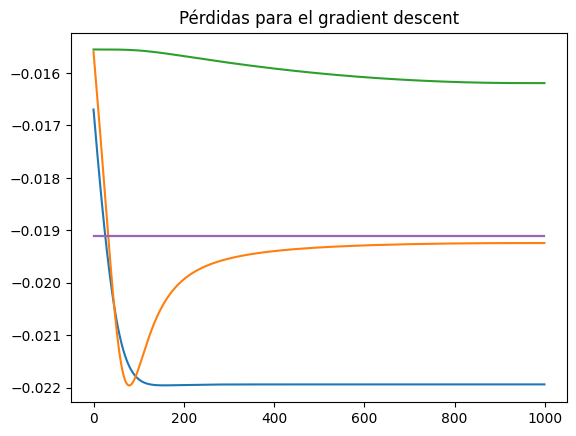

In [11]:
print(np.shape(loss_vect))
plt.plot(loss_vect)
plt.title('Pérdidas para el gradient descent')

In [12]:
lps = loss(map_estimate)
theta_map = map_estimate[jnp.nanargmin(lps)][jnp.newaxis,:][0]
print(lps)
print(theta_map)
print(get_parameters_from_z(theta_map))
print(loss(theta_map))

[-0.02193826 -0.01924251 -0.01619218 -0.01910329 -0.01910329]
[2.1820736e+00 6.1207204e+00 1.3500841e-01 3.0222820e+20 7.0601676e+15]
(Array(0.4774238, dtype=float32), Array(7.484656e-05, dtype=float32), Array(0.01533701, dtype=float32), Array(4.999987e+20, dtype=float32), Array(9.999978e+15, dtype=float32))
-0.022638889


In [13]:
from jax import config
config.update("jax_enable_x64", False)

# Convertimos el tuple de arrays a un solo array
array_result = jnp.array(theta_map)
print(array_result)

schedule_fn = optax.polynomial_schedule(init_value=0, end_value=-3e-3,
                                      power=0.5, transition_steps=1000)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),)

q_z, losses = SVI(start=array_result, optimizer=opt, n_vi=1000, num_steps=2500)


[2.1820736e+00 6.1207204e+00 1.3500841e-01 3.0222820e+20 7.0601676e+15]


<ipython-input-6-8750f50bc4cc>:67: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  replicated_params = jax.tree_map(lambda x: jnp.array([x] * dev_cnt), qz_params)


  0%|          | 0/2500 [00:00<?, ?it/s]

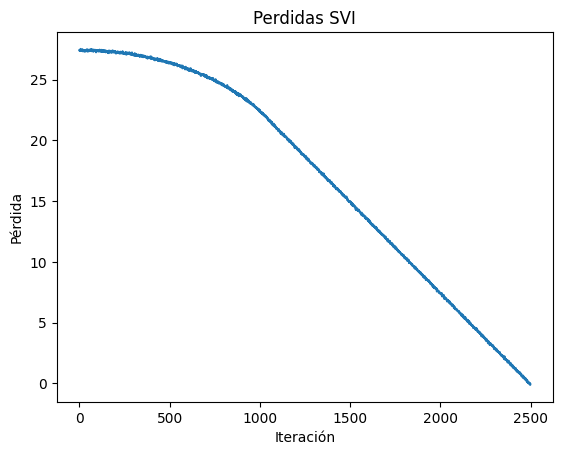

In [14]:
plt.figure()
plt.plot(losses)
plt.title('Perdidas SVI')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
mean_svi=q_z.mean()
cov=q_z.covariance()
scale = np.linalg.cholesky(cov)

In [15]:
print(get_parameters_from_z(mean_svi))

(Array(0.47745588, dtype=float32), Array(7.498629e-05, dtype=float32), Array(0.01555764, dtype=float32), Array(4.999987e+20, dtype=float32), Array(9.999978e+15, dtype=float32))


In [16]:
import numpy as np
import corner

# Supongamos que qz es un objeto de distribución con métodos de media y covarianza
qz = q_z
numparams = 5

# Obtener media y covarianza
mean = qz.mean()
cov = qz.covariance()

# Realizamos la descomposición de Cholesky de la covarianza
L = np.linalg.cholesky(cov)

# Generar muestras
n = 10000000
d = numparams
u = np.random.normal(loc=0, scale=1, size=d * n).reshape(d, n)

# Asegurarnos que la media tiene la forma correcta
mean = np.array(mean).reshape(d, 1)

# Generar las muestras de los parámetros
x = mean + np.dot(L, u)

# Transponemos para tener las muestras en las filas
a = x.T
b = np.array(a)

#for i in range(np.shape(b)[0]):
#  b[i,:]=get_parameters_from_z(b[i,:])

#Convertir 'b' a un array de JAX para aprovechar la GPU
b_jax = jnp.array(b)

# Vectorizar la función get_parameters_from_z usando jax.vmap
vectorized_get_parameters_from_z = jax.vmap(get_parameters_from_z)

# Aplicar la función vectorizada a todas las filas de 'b'
b_jax_transformed = vectorized_get_parameters_from_z(b_jax)

# Si deseas convertir el array de JAX de nuevo a NumPy (si es necesario)
b = np.array(b_jax_transformed).T

print(b)

# Definir rangos para cada uno de los 5 parámetros
ranges = [
    (0, 1),            # Rango más amplio para V
    (-1e-3, 1e-3),         # Rango más amplio para W_n
    (100e-4, 200e-4),   # Rango más amplio para W_p
    (4.9e20, 5.1e20),      # Rango más amplio para N_D
    (0.99e16, 1.01e16)       # Rango más amplio para N_A
]

# Filtrar las muestras que estén fuera de los rangos
mask = (
    (b[:, 0] >= ranges[0][0]) & (b[:, 0] <= ranges[0][1]) &  # V
    (b[:, 1] >= ranges[1][0]) & (b[:, 1] <= ranges[1][1]) &  # W_n
    (b[:, 2] >= ranges[2][0]) & (b[:, 2] <= ranges[2][1]) &  # W_p
    (b[:, 3] >= ranges[3][0]) & (b[:, 3] <= ranges[3][1]) &  # N_D
    (b[:, 4] >= ranges[4][0]) & (b[:, 4] <= ranges[4][1])    # N_A
)

# Aplicar la máscara a las muestras
b_filtered = b[mask]
# Generar el gráfico corner con las muestras filtradas
import numpy as np
import corner
# Definir rangos más amplios para cada uno de los 5 parámetros
# Definir rangos más amplios para cada uno de los 5 parámetros
ranges = [
    (0.5, 0.53),         # Ampliar el rango para V
    (2.9e-3, 3.1e-3),    # Ampliar el rango para W_n
    (4.5e-2, 5.5e-2),    # Ampliar el rango para W_p
    (4.9e20, 5.1e20),    # Mantener el rango para N_D
    (0.99e16, 1.01e16)   # Mantener el rango para N_A
]

# Filtrar las muestras que estén fuera de los rangos
mask = (
    (b[:, 0] >= ranges[0][0]) & (b[:, 0] <= ranges[0][1]) &  # V
    (b[:, 1] >= ranges[1][0]) & (b[:, 1] <= ranges[1][1]) &  # W_n
    (b[:, 2] >= ranges[2][0]) & (b[:, 2] <= ranges[2][1]) &  # W_p
    (b[:, 3] >= ranges[3][0]) & (b[:, 3] <= ranges[3][1]) &  # N_D
    (b[:, 4] >= ranges[4][0]) & (b[:, 4] <= ranges[4][1])    # N_A
)

# Aplicar la máscara a las muestras
b_filtered = b[mask]

# Verificar si hay muestras en b_filtered
print("Shape of b_filtered after applying mask:", b_filtered.shape)

# Si b_filtered tiene muestras, generar el gráfico corner
if b_filtered.shape[0] > 0:
    figure = corner.corner(
        b_filtered,
        show_titles=True,
        title_fmt='.3e',
        labels=[r'$V$', r'$W_n$', r'$W_p$', r'$N_D$', r'$N_A$'],
        range=ranges,
        label_kwargs={'fontsize': 17},
        title_kwargs={'fontsize': 17},
        color='blue',
        bins=14,
        smooth=1.0,
        levels=(0.68, 0.95),
        plot_contours=True,
        fill_contours=False,
    )
    plt.show()
else:
    print("No samples within the specified ranges.")


[[4.8974580e-01 7.4986863e-05 1.5426073e-02 4.9999871e+20 9.9999777e+15]
 [4.7964096e-01 7.4988522e-05 1.5891789e-02 4.9999871e+20 9.9999777e+15]
 [4.8198113e-01 7.4987343e-05 1.6472468e-02 4.9999871e+20 9.9999777e+15]
 ...
 [4.8264614e-01 7.4991884e-05 1.5330587e-02 4.9999871e+20 9.9999777e+15]
 [4.6733224e-01 7.4987838e-05 1.4389634e-02 4.9999871e+20 9.9999777e+15]
 [4.6806431e-01 7.4985728e-05 1.5452698e-02 4.9999871e+20 9.9999777e+15]]
Shape of b_filtered after applying mask: (0, 5)
No samples within the specified ranges.


In [17]:
jax.config.update("jax_enable_x64", False)

n_hmc=2000
num_results=7500
num_burnin_steps=2500
dev_cnt=jax.device_count()
num_params=5
samples,sample_stats= HMC(q_z,init_eps=0.00001,
        init_l=1,
        n_hmc=n_hmc,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results,
        num_step_between_results=3000
        max_leapfrog_steps=30,
        seed=0,
        accept=0.75
    )

shape of start (2000, 5)
Sampling took 7.5s


In [18]:
print(np.shape(samples))
num_params=5

(1, 7500, 2000, 5)


In [19]:
samples_res=jnp.reshape(samples,(num_results,n_hmc,num_params))
print(np.shape(samples_res))

Rhat = tfp.mcmc.potential_scale_reduction(jnp.array(samples_res))
print(Rhat)

(7500, 2000, 5)
[nan nan nan nan nan]


In [37]:
samples_res_res=jnp.reshape(samples,(num_results*dev_cnt*(n_hmc//dev_cnt),num_params))
a = vectorized_get_parameters_from_z(samples_res_res)
best_HMC = np.mean(np.array(a).T,axis=0)
print(best_HMC)
print(loss(best_HMC))

SyntaxError: invalid syntax (<ipython-input-37-d747f4488147>, line 5)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

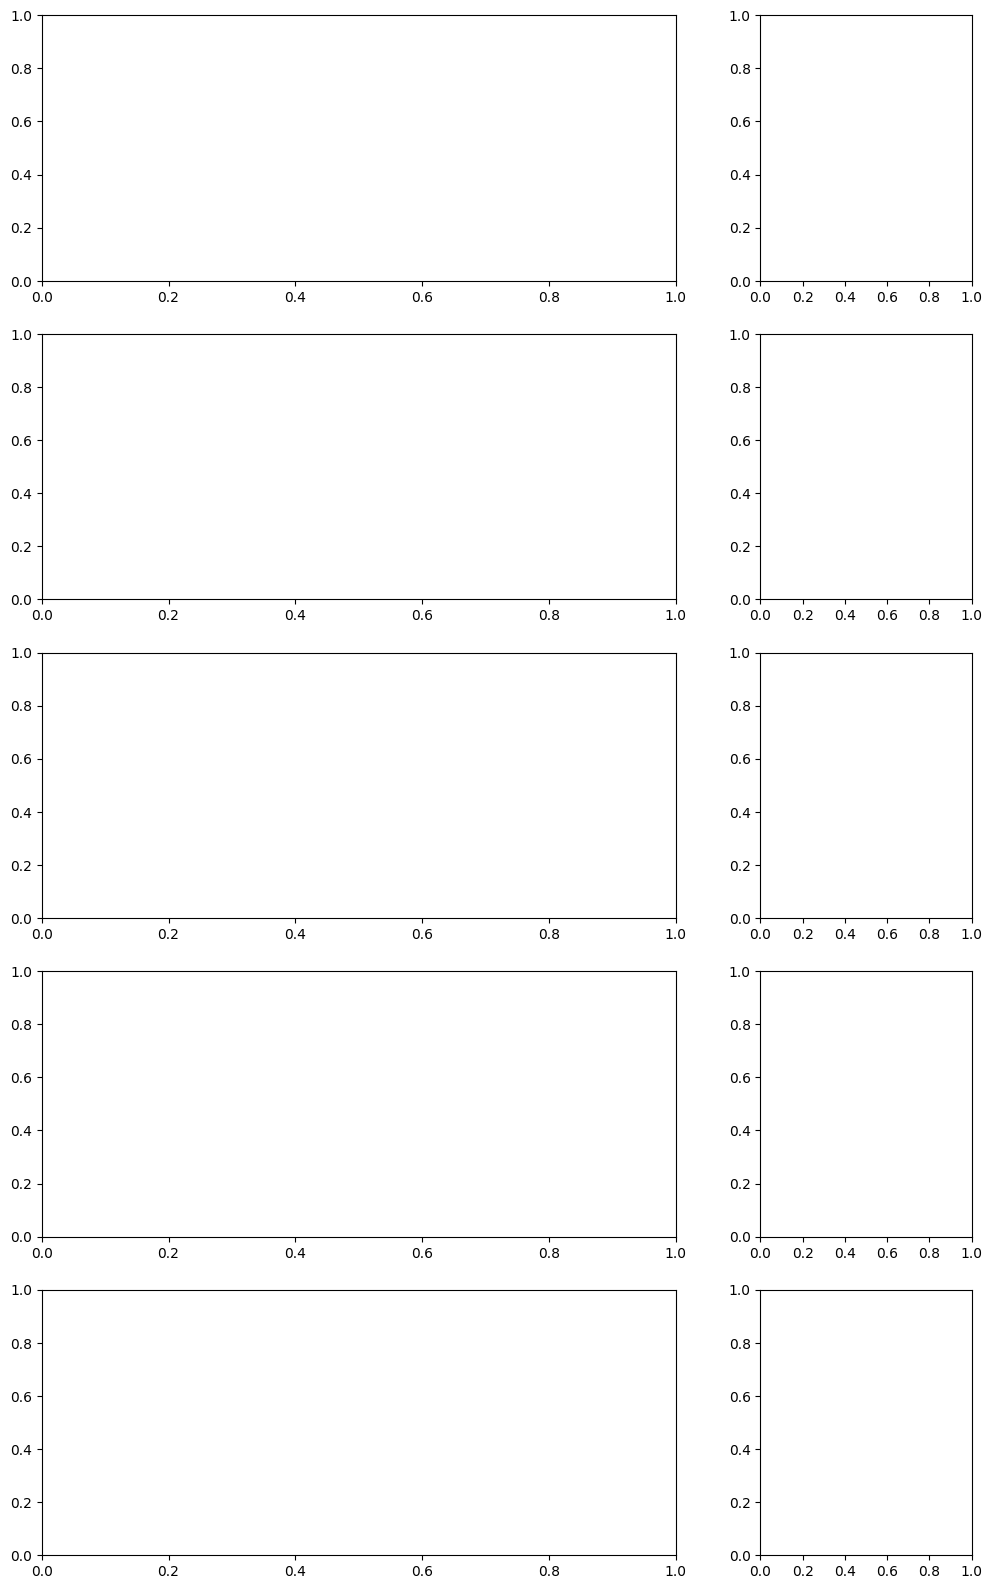

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.gridspec as gridspec

num_chains = 8
# Colores ajustados para las cadenas
colors = ['#6b5b95', '#feb236', '#d64161', '#ff7b25', '#3e4444', '#98c1d9', '#3d5a80', '#ee6c4d']

# Títulos para los parámetros
param_titles = [
    'V',   # Index 0
    'W_n',      # Index 1
    'W_p', # Index 2
    'N_D',     # Index 3
    'N_A'      # Index 4
]

# Configurar la figura con subplots
fig, axs = plt.subplots(len(param_titles), 2, figsize=(12, 20), gridspec_kw={'width_ratios': [3, 1]})

# Genera las trazas y los histogramas para cada parámetro
for idx, title in enumerate(param_titles):
    # Trazas de las cadenas
    for i in range(num_chains):
        axs[idx, 0].plot(samples_res[:, i, idx], color=colors[i], label=f'Cadena {i}', alpha=0.6)
    axs[idx, 0].set_title(f'{title} trace')
    axs[idx, 0].grid(True)

    # Histograma y ajuste normal
    for i in range(num_chains):
        chain_data = samples_res[:, i, idx]
        if np.ptp(chain_data) > 0:  # np.ptp devuelve el rango de valores (máximo - mínimo)
            prob, bins = np.histogram(chain_data, density=True, bins=40)
            (mu, sigma) = norm.fit(chain_data)
            y = norm.pdf(bins[:-1], mu, sigma)
            axs[idx, 1].plot(y, bins[:-1], color=colors[i], linewidth=2, alpha=0.8)

    axs[idx, 1].grid(True)
    axs[idx, 1].tick_params(axis='y', labelsize=0)
    axs[idx, 1].get_xaxis().set_visible(False)

# Ajustar el layout para que no se sobrepongan las etiquetas
plt.tight_layout()
plt.show()


In [28]:
np.mean(samples_res,axis=0)

array([4.77377568e-01, 7.50193581e-05, 1.99921379e-02, 5.00073014e+20,
       9.99408229e+15])

In [29]:
b=samples_res_res

b_jax = jnp.array(b)
b_jax_transformed = vectorized_get_parameters_from_z(b_jax)

# Si deseas convertir el array de JAX de nuevo a NumPy (si es necesario)
b = np.array(b_jax_transformed).T

# Definir rangos para cada uno de los 5 parámetros
ranges = [
    (0, 1),            # Rango más amplio para V
    (-1e-3, 1e-3),         # Rango más amplio para W_n
    (100e-4, 200e-4),   # Rango más amplio para W_p
    (4.9e20, 5.1e20),      # Rango más amplio para N_D
    (0.99e16, 1.01e16)       # Rango más amplio para N_A
]

# Filtrar las muestras que estén fuera de los rangos
mask = (
    (b[:, 0] >= ranges[0][0]) & (b[:, 0] <= ranges[0][1]) &  # V
    (b[:, 1] >= ranges[1][0]) & (b[:, 1] <= ranges[1][1]) &  # W_n
    (b[:, 2] >= ranges[2][0]) & (b[:, 2] <= ranges[2][1]) &  # W_p
    (b[:, 3] >= ranges[3][0]) & (b[:, 3] <= ranges[3][1]) &  # N_D
    (b[:, 4] >= ranges[4][0]) & (b[:, 4] <= ranges[4][1])    # N_A
)

# Aplicar la máscara a las muestras
b_filtered = b[mask]
# Generar el gráfico corner con las muestras filtradas
# Generar el gráfico corner con más muestras y suavizado
figure = corner.corner(
    b_filtered,
    show_titles=True,
    title_fmt='.2e',
    labels=[r'$V$', r'$W_n$', r'$W_p$', r'$N_D$', r'$N_A$'],
    range=ranges,  # Definir el rango para cada parámetro
    label_kwargs={'fontsize': 17},
    title_kwargs={'fontsize': 17},
    bins=10,  # Aumentar el número de bins para un histograma más detallado
    smooth=1.0,  # Suavizar los contornos
    levels=(0.68, 0.95),  # Niveles para contornos más bonitos
    plot_contours=True,  # Dibujar contornos
    fill_contours=False,  # Rellenar los contornos
)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not ArrayImpl

-0.022638889


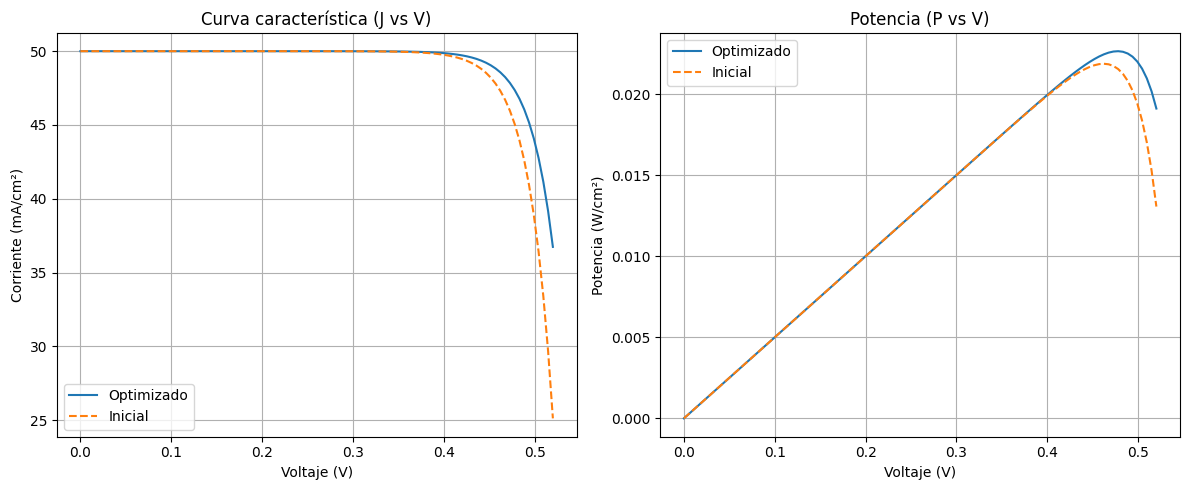

Potencia máxima inicial: 0.02186554859214446


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Constantes
q = 1.602176634e-19  # Carga elemental en C
k = 1.3880649e-23  # Constante de Boltzmann en J/K
T = 300  # Temperatura en K
epsilon = 1.035918e-12  # Permitividad eléctrica del silicio en F/cm
n_i = 9.696e9  # Concentración intrínseca de portadores en cm^-3
J_L = 50e-3  # Densidad de corriente generada por la luz en A/cm^2

# Definir la función coth(x)
def coth(x):
    return np.cosh(x) / np.sinh(x) if np.sinh(x) != 0 else 1

# Definir la función para calcular V_int
def calculate_V_int(N_A, N_D):
    return (k * T / q) * np.log(N_A * N_D / n_i**2)

# Definir la función para calcular X_n y X_p
def calculate_X_n(V_int, epsilon, q, N_A, N_D):
    return np.sqrt(2 * epsilon * V_int / q * (N_A / (N_D * (N_A + N_D))))

def calculate_X_p(V_int, epsilon, q, N_A, N_D):
    return np.sqrt(2 * epsilon * V_int / q * (N_D / (N_A * (N_A + N_D))))

# Calcular J_D
def calculate_J_D(V, W_n, W_p, N_D, N_A):
    V_int = calculate_V_int(N_A, N_D)
    X_n = calculate_X_n(V_int, epsilon, q, N_A, N_D)
    X_p = calculate_X_p(V_int, epsilon, q, N_A, N_D)
    exponential_term = (np.exp(q * V / (k * T)) - 1) * n_i**2

    D_n = 2  # cm^2/s
    tau_n = 371e-6  # s
    term_1 = np.sqrt(D_n / tau_n) / N_A * coth((X_p + W_n) / np.sqrt(D_n * tau_n))

    D_p = 11.6  # cm^2/s
    tau_p = 3710e-6  # s
    term_2 = np.sqrt(D_p / tau_p) / N_D * coth((X_n + W_p) / np.sqrt(D_p * tau_p))

    J_D = q * exponential_term * (term_1 + term_2)
    return J_D

# Calcular la potencia
def calculate_power(params):
    V, W_n, W_p, N_D, N_A = params
    J_D = calculate_J_D(V, W_n, W_p, N_D, N_A)
    J = J_L - J_D
    P = J * V
    return -P

# Rango de parámetros
bounds = [
    (0.1, 0.52),  # V
    (0.05e-4, 0.75e-4),  # W_n
    (100e-4, 200e-4),  # W_p
    (1e18, 5e20),  # N_D
    (1e14, 1e16)  # N_A
]

# Optimización
optimal_params = best_HMC
print(loss(theta_map))
# Parámetros optimizados
optimal_params = result.x


# Valores no optimizados
W_n_initial, W_p_initial, N_D_initial, N_A_initial = 0.75e-4, 200e-4, 1e20, 4.7e15

# Rango de voltaje
V_values = np.linspace(0, 0.52, 100)

# J_D para valores optimizados
J_D_values_optimized = np.array([calculate_J_D(V, optimal_params[1], optimal_params[2], optimal_params[3], optimal_params[4]) for V in V_values])
J_values_optimized = J_L - J_D_values_optimized
P_values_optimized = J_values_optimized * V_values

# J_D para valores iniciales
J_D_values_initial = np.array([calculate_J_D(V, W_n_initial, W_p_initial, N_D_initial, N_A_initial) for V in V_values])
J_values_initial = J_L - J_D_values_initial
P_values_initial = J_values_initial * V_values

# Graficar corriente (J vs V) y potencia (P vs V)
plt.figure(figsize=(12, 5))

# Gráfico J vs V
plt.subplot(1, 2, 1)
plt.plot(V_values, J_values_optimized * 1e3, label='Optimizado')  # Convertir A/cm² a mA/cm²
plt.plot(V_values, J_values_initial * 1e3, label='Inicial', linestyle='--')  # No optimizado
plt.title('Curva característica (J vs V)')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (mA/cm²)')
plt.grid(True)
plt.legend()

# Gráfico P vs V
plt.subplot(1, 2, 2)
plt.plot(V_values, P_values_optimized, label='Optimizado')  # Potencia optimizada
plt.plot(V_values, P_values_initial, label='Inicial', linestyle='--')  # Potencia inicial
plt.title('Potencia (P vs V)')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W/cm²)')
plt.grid(True)
plt.legend()

# Mostrar gráficos
plt.tight_layout()
plt.show()

# Mostrar potencia máxima no optimizada
print("Potencia máxima inicial:", np.max(P_values_initial))
